## Kaulos RNN Tests
These tests require the keras master branch.

In [1]:
from kaulos import *
from keras.layers.recurrent import RNN

class KaulosWrapperCell(keras.layers.Layer):
    def __init__(self, layers, **kwargs):
        self.units = 0
        self.unit_sizes = []
        self.state_size = []
        self.state_sizes = []
        self.layers = layers
        for i in self.layers:
            self.units += i.units
            self.unit_sizes.append(i.units)
            self.state_size += i.state_size
            self.state_sizes.append(sum(i.state_size))
        print(self.state_size)
        super(KaulosWrapperCell, self).__init__(**kwargs)
    def build(self, input_shape):
        for i in self.layers:
            i.build(input_shape)
        self.built = True
    def call(self, inputs, states):
        # Initialize circuit 
        out_states = []
        outs = []
        ii = 0
        for i in self.layers:
            print(range(int(sum(self.unit_sizes[:ii])),int(sum(self.unit_sizes[:ii+1]))))
            print(range(int(sum(self.state_sizes[:ii])),int(sum(self.state_sizes[:ii+1]))))
            unit_range = range(int(sum(self.unit_sizes[:ii])),int(sum(self.unit_sizes[:ii+1])))
            state_range = range(int(sum(self.state_sizes[:ii])),int(sum(self.state_sizes[:ii+1])))
            print(inputs[:,unit_range])
            print(states)
            print(states[[state_range]])
            a, b = i.call(inputs[:,unit_range],states[state_range])
            out_states += b
            outs += [a]
            ii += 1
        # Combine all outputs into a single tensor
        output = outs[0]
        if len(outs)>1:
            for i in range(len(outs)-1):
                output = K.concatenate([output, outs[i+1]], axis=-1)
        # Finally, add the outputs to the output states
        out_states = [output] + out_states
        return output, out_states

component = LeakyIAF()
cell = KaulosWrapperCell([component])
x = keras.Input((100L, 1L,))
layer = RNN(cell)
y = layer(x)

model = Model(inputs=x, outputs=y)

optimizer = Adam()
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


[2]
[0, 1]
[0, 1]
InplaceDimShuffle{1,0}.0
(<TensorType(float32, matrix)>,)


TypeError: tuple indices must be integers, not list

## Component Level Tests
These tests require a rewrite.

In [1]:
from kaulos import *

M = 1
T = 100
x_train = np.abs(np.random.randn(1,T,M)) * 0.1

a = Input(shape=x_train.shape[2:])
b = LeakyIAF()(a)
model = Model(inputs=a, outputs=b[0])

optimizer = Adam()
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.summary()

import time
start = time.time()
As = []
for i in range(x_train.shape[1]):
    model.train_on_batch(x_train[0,i,:], x_train[0,i,:])
    As.append(model.predict(x_train[0,i,:]))
end = time.time()
print(end - start)

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


(None, 1L)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1L)                0         
_________________________________________________________________
leaky_iaf_1 (LeakyIAF)       [(None, 1L), (None, 1L)]  2         
Total params: 2
Trainable params: 0
Non-trainable params: 2
_________________________________________________________________
8.02900004387


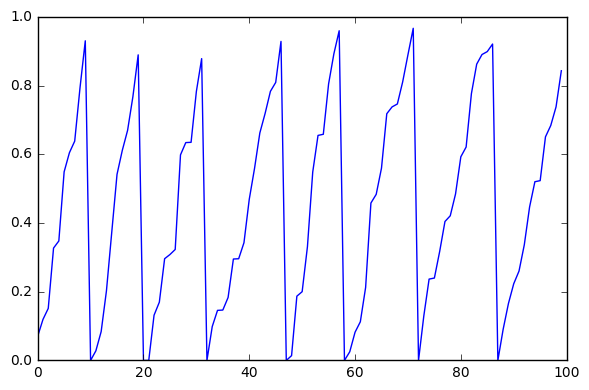

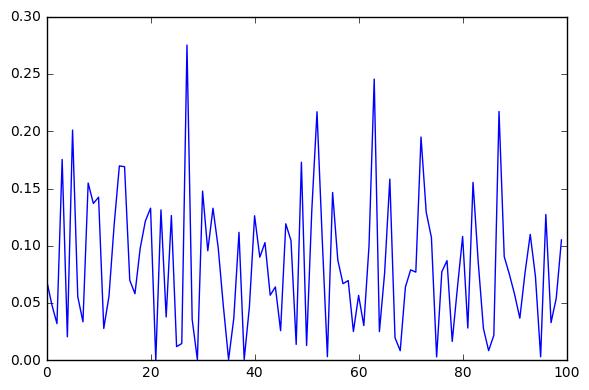

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.array(As)[:,0,0])
plt.tight_layout()

plt.figure()
plt.plot(x_train[0,:,0])
plt.tight_layout()

In [3]:
from kaulos import *

M = 1
T = 100000
x_train = np.abs(np.random.randn(1,T,M)) * 0. + 10.0

N = M
b = np.eye(N).reshape((N,N))

a = Input(shape=x_train.shape[2:])
b = HodgkinHuxley()(a)
model = Model(inputs=a, outputs=b[0])
optimizer = Adam()
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()


import time
start = time.time()
As = []
for i in range(x_train.shape[1]):
    model.train_on_batch(x_train[0,i,:], x_train[0,i,:])
    As.append(model.predict(x_train[0,i,:]))
end = time.time()
print(end - start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1L)                0         
_________________________________________________________________
hodgkin_huxley_1 (HodgkinHux [(None, 1L), (None, 1L)]  5         
Total params: 5
Trainable params: 0
Non-trainable params: 5
_________________________________________________________________
55.9760000706


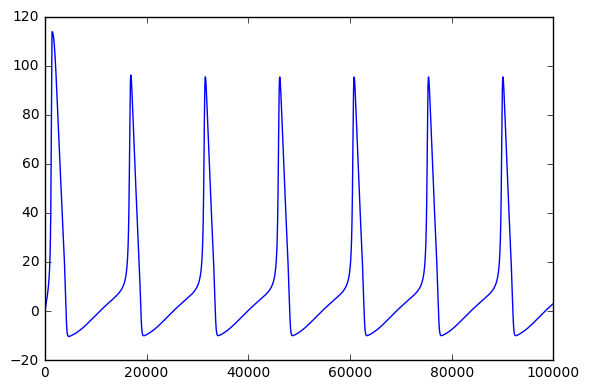

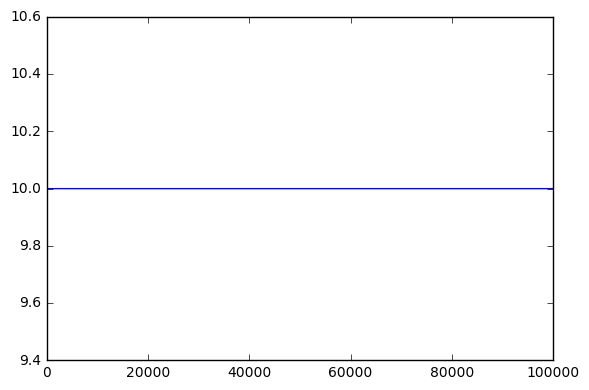

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.array(As)[:,0,0])
plt.tight_layout()

plt.figure()
plt.plot(x_train[0,:,0])
plt.tight_layout()

In [5]:
from kaulos import *

M = 1
T = 10000
x_train = np.greater(np.abs(np.random.randn(1,T,M)), 3.00) * 1.0

N = M
b = np.eye(N).reshape((N,N))

a = Input(shape=x_train.shape[2:])
b = AlphaSynapse()(a)
model = Model(inputs=a, outputs=b)

optimizer = Adam()
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()


import time
start = time.time()
As = []
for i in range(x_train.shape[1]):
    model.train_on_batch(x_train[0,i,:], x_train[0,i,:])
    As.append(model.predict(x_train[0,i,:]))
end = time.time()
print(end - start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1L)                0         
_________________________________________________________________
alpha_synapse_1 (AlphaSynaps (None, 1L)                4         
Total params: 4
Trainable params: 0
Non-trainable params: 4
_________________________________________________________________
12.4709999561


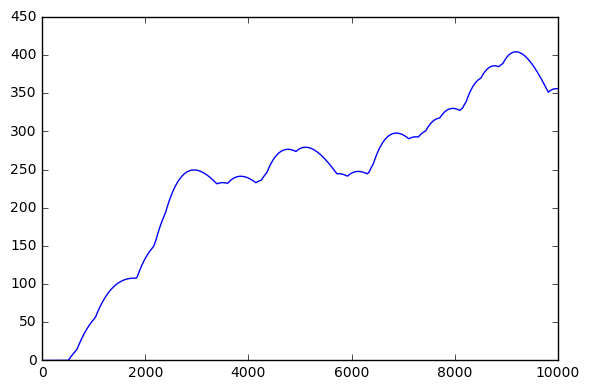

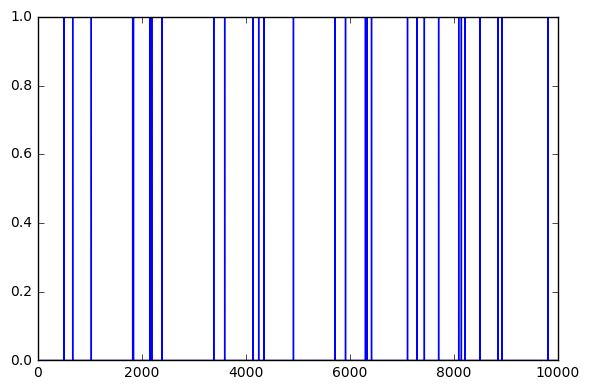

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.array(As)[:,0,0])
plt.tight_layout()

plt.figure()
plt.plot(x_train[0,:,0])
plt.tight_layout()

In [1]:
from kaulos import *

M = 100
T = 100
x_train = np.abs(np.random.randn(1,T,M)) * 0.1

a = Input(shape=(100,))
b = Lambda(lambda x: x[:,0:1], output_shape=(1L,))(a)
c = LeakyIAF()(b)
model = Model(inputs=a, outputs=c[0])

optimizer = Adam()
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.summary()

import time
start = time.time()
As = []
for i in range(x_train.shape[1]):
    model.train_on_batch(x_train[0,i:i+1,:], x_train[0,i:i+1,0:1])
    As.append(model.predict(x_train[0,i:i+1,:]))
end = time.time()
print(end - start)

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


(None, 1L)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1L)                0         
_________________________________________________________________
leaky_iaf_1 (LeakyIAF)       [(None, 1L), (None, 1L)]  2         
Total params: 2
Trainable params: 0
Non-trainable params: 2
_________________________________________________________________
8.29799985886
